## Imports and data ingestion

`linear_model` for Logistic Regression,

`model_selection` for train-test split and cross-validation,

`metrics` for ROC and AIC

In [2120]:
import numpy as np
import pandas as pd
import sklearn.linear_model as skl_lm
import sklearn.ensemble as skl_en
import sklearn.model_selection as skl_ms
import sklearn.metrics as skl_met
import sklearn.preprocessing as skl_pre

In [2121]:
rawData = pd.read_csv('train.csv')

## Get Dummies

`Lead` is `0` if the lead is `female`.

In [2122]:
data = rawData.copy()
data['Lead'] = pd.get_dummies(data['Lead'])

## Feature Engineering

We first extract the number of words spoken by the co-lead.

In [2123]:
data['Number of words co-lead'] = data['Number of words lead'] - data['Difference in words lead and co-lead']

It is probably more important to know proportion of words spoken by lead than the absolute number of words.

In [2124]:
data['Proportion of words lead'] = data['Number of words lead']/data['Total words']

We look at the proportion of dialogue from co-lead as well as the ratio of dialogue between co-lead and lead.

In [2125]:
data['Proportion of words co-lead'] = data['Number of words co-lead']/data['Total words']
data['Ratio words co-lead lead'] = data['Number of words co-lead']/data['Number of words lead']

Similarly for number of words spoken by male or female actors. However, here we normalize by `Total words - Number of words lead` since this only measures non-lead dialogue. We only need `Proportion of words female` since a hypothetical `Proportion of words male` is just `1 - Proportion of words female`.

In [2126]:
data['Proportion of words female'] = data['Number words female']/(data['Total words'] - data['Number of words lead'])

It might be important to look at the ratio of female actors.

In [2127]:
data['Number of actors'] = data['Number of male actors'] + data['Number of female actors']

In [2128]:
data[['Total words','Number of words lead','Difference in words lead and co-lead','Number of words co-lead','Number words male','Number words female']]

,Total words,Number of words lead,Difference in words lead and co-lead,Number of words co-lead,Number words male,Number words female
0,6394,2251.0,343,1908.0,2631,1512
1,8780,2020.0,1219,801.0,5236,1524
2,4176,942.0,787,155.0,3079,155
3,9855,3440.0,2623,817.0,5342,1073
4,7688,3835.0,3149,686.0,2536,1317
...,...,...,...,...,...,...
1034,2398,1334.0,1166,168.0,761,303
1035,8404,1952.0,187,1765.0,5820,632
1036,2750,877.0,356,521.0,547,1326
1037,3994,775.0,52,723.0,2757,462


In [2129]:
data['Proportion of female actors'] = data['Number of female actors']/data['Number of actors']

Perhaps it is important if the lead or co-lead is oldest.

In [2130]:
data['Older lead'] = data['Age Lead'] < data['Age Co-Lead']
data['Older lead'] = pd.get_dummies(data['Older lead'])

In [2131]:
for col in data.columns:
    print("'" + col + "',")

'Number words female',
'Total words',
'Number of words lead',
'Difference in words lead and co-lead',
'Number of male actors',
'Year',
'Number of female actors',
'Number words male',
'Gross',
'Mean Age Male',
'Mean Age Female',
'Age Lead',
'Age Co-Lead',
'Lead',
'Number of words co-lead',
'Proportion of words lead',
'Proportion of words co-lead',
'Ratio words co-lead lead',
'Proportion of words female',
'Number of actors',
'Proportion of female actors',
'Older lead',


We center and scale all computed columns as well as some of the original columns

In [2132]:
cols_to_norm = [
    'Total words',
    'Year',
    'Gross',
    'Mean Age Male',
    'Mean Age Female',
    'Age Lead',
    'Age Co-Lead',
    'Number of actors',
    'Proportion of words lead',
    'Proportion of words co-lead',
    'Ratio words co-lead lead',
    'Proportion of words female',
    'Proportion of female actors',
    'Older lead'
]

In [2133]:
scaler = skl_pre.StandardScaler()
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])

In [2134]:
data

,Number words female,Total words,Number of words lead,Difference in words lead and co-lead,Number of male actors,Year,Number of female actors,Number words male,Gross,Mean Age Male,...,Age Co-Lead,Lead,Number of words co-lead,Proportion of words lead,Proportion of words co-lead,Ratio words co-lead lead,Proportion of words female,Number of actors,Proportion of female actors,Older lead
0,1512,-0.676591,2251.0,343,2,-0.467462,5,2631,0.203383,1.170591,...,2.451143,1,1908.0,-0.172223,1.848446,1.605265,0.091674,-0.940919,2.463347,-1.370444
1,1524,-0.326435,2020.0,1219,9,0.109371,4,5236,-0.488825,-0.413237,...,-0.123416,0,801.0,-1.167466,-0.695841,-0.156442,-0.571524,0.379885,-0.096459,0.729691
2,155,-1.002092,942.0,787,7,-3.063211,1,3079,1.746018,0.018716,...,0.125734,0,155.0,-1.204130,-1.360398,-1.062474,-1.415397,-0.720785,-1.246642,0.729691
3,1073,-0.168675,3440.0,2623,12,0.205509,2,5342,-0.607490,-0.912739,...,-1.036970,0,817.0,-0.196598,-0.798116,-0.777545,-0.848098,0.600019,-1.134218,0.729691
4,1317,-0.486691,3835.0,3149,8,-1.140434,4,2536,-0.469048,0.370678,...,0.291835,0,686.0,1.025364,-0.720404,-1.006488,-0.018335,0.159751,0.064971,-1.370444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,303,-1.263021,1334.0,1166,5,-2.582517,2,761,0.414341,0.108306,...,-0.953919,0,168.0,1.494244,-0.955847,-1.213250,-0.289478,-0.940919,-0.234826,0.729691
1035,632,-0.381615,1952.0,187,6,-0.755879,2,5820,0.401156,-0.663877,...,-0.123416,1,1765.0,-1.149500,0.762992,1.826226,-1.177584,-0.720785,-0.459674,-1.370444
1036,1326,-1.211363,877.0,356,2,0.013232,3,547,-0.383346,-1.901076,...,-0.870869,0,521.0,-0.442611,0.510442,0.615026,1.722238,-1.381187,1.743834,0.729691
1037,462,-1.028801,775.0,52,8,-0.371324,3,2757,-0.521788,0.064425,...,-0.289517,1,723.0,-1.461414,0.406877,1.938322,-0.960960,-0.060383,-0.316589,-1.370444


Combining all pre-processing into a function

In [2135]:
def pre_process(raw_data, cols_to_norm):
    data = raw_data.copy()
    
    data['Lead'] = pd.get_dummies(data['Lead'])
    data['Number of words co-lead'] = data['Number of words lead'] - data['Difference in words lead and co-lead']
    data['Proportion of words lead'] = data['Number of words lead']/data['Total words']
    data['Proportion of words co-lead'] = data['Number of words co-lead']/data['Total words']
    data['Ratio words co-lead lead'] = data['Number of words co-lead']/data['Number of words lead']
    data['Proportion of words female'] = data['Number words female']/(data['Total words'] - data['Number of words lead'])
    data['Number of actors'] = data['Number of male actors'] + data['Number of female actors']
    data['Proportion of female actors'] = data['Number of female actors']/data['Number of actors']
    data['Older lead'] = data['Age Lead'] < data['Age Co-Lead']
    data['Older lead'] = pd.get_dummies(data['Older lead'])
    
    scaler = skl_pre.StandardScaler()
    data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])
    
    return data

# Logistic Regression

In [2136]:
data = pre_process(rawData, cols_to_norm)

In [2137]:
config = pd.read_csv('config.csv')
trainRatio = config['Train Ratio'][0]
seed = config['Random Seed'][0]
train, test = skl_ms.train_test_split(data, train_size=trainRatio) #, random_state=seed)

In [2138]:
rawFeatures = [
    'Number words female',
    'Total words',
    'Number of words lead',
    'Difference in words lead and co-lead',
    'Number of male actors',
    'Year',
    'Number of female actors',
    'Number words male',
    'Gross',
    'Mean Age Male',
    'Mean Age Female',
    'Age Lead',
    'Age Co-Lead'
]

featureSet1 = [
    'Year',
    'Gross',
    'Number of actors',
    'Proportion of female actors',
    'Mean Age Male',
    'Mean Age Female',
    'Age Lead',
    'Age Co-Lead',
    'Total words',
    'Proportion of words lead',
    'Proportion of words co-lead',
    'Ratio words co-lead lead',
    'Proportion of words female',
    'Older lead'
]

In [2139]:
set(cols_to_norm) == set(featureSet1) 

True

In [2140]:
features = featureSet1.copy()
#features.remove('Proportion of words female')
target = 'Lead'

## Lasso

Lasso is L1 regularization

We do 20 folds, use `liblinear` solver that is better for smaller datasets and 10 threads in the cross-validation step.

The method will try 10 values of lambda between `1e-4` and `1e4` to determine the best regularization parameter.

In [2141]:
logRegLasso = skl_lm.LogisticRegressionCV(Cs=10, cv=20, penalty='l1', solver='liblinear', n_jobs=10)

In [2142]:
logRegLasso.fit(train[features], train[target])

LogisticRegressionCV(cv=20, n_jobs=10, penalty='l1', solver='liblinear')

In [2143]:
logRegLasso.score(test[features], test[target])

0.9230769230769231

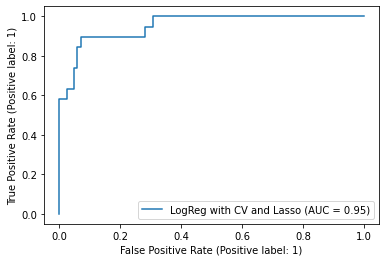

In [2144]:
skl_met.plot_roc_curve(logRegLasso, test[features], test[target], name='LogReg with CV and Lasso')

In [2145]:
skl_met.roc_auc_score(test[target], logRegLasso.predict_proba(test[features])[:,1])

0.9529411764705882

In [2146]:
print(skl_met.classification_report(test[target], logRegLasso.predict(test[features])))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        85
           1       0.74      0.89      0.81        19

    accuracy                           0.92       104
   macro avg       0.86      0.91      0.88       104
weighted avg       0.93      0.92      0.93       104



## Ridge

Ridge is L2-regularization

We do 10 folds, use `liblinear` solver that is better for smaller datasets and 10 threads in the cross-validation step.

The method will try 100 values of lambda between `1e-4` and `1e4` to determine the best regularization parameter.

In [2147]:
logRegRidge = skl_lm.LogisticRegressionCV(Cs=10, cv=10, penalty='l2', solver='liblinear', n_jobs=10)
logRegRidge.fit(train[features], train[target])

LogisticRegressionCV(cv=10, n_jobs=10, solver='liblinear')

In [2148]:
logRegRidge.score(test[features], test[target])

0.9230769230769231

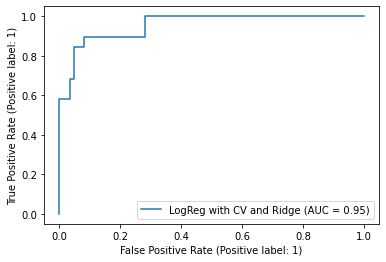

In [2149]:
skl_met.plot_roc_curve(logRegRidge, test[features], test[target], name='LogReg with CV and Ridge')

In [2150]:
skl_met.roc_auc_score(test[target], logRegRidge.predict_proba(test[features])[:,1])

0.9547987616099072

In [2151]:
print(skl_met.classification_report(test[target], logRegRidge.predict(test[features])))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        85
           1       0.76      0.84      0.80        19

    accuracy                           0.92       104
   macro avg       0.86      0.89      0.88       104
weighted avg       0.93      0.92      0.92       104



## Comparison

In [2152]:
logRegLasso.C_

array([0.35938137])

In [2153]:
logRegRidge.C_

array([0.35938137])

In [2154]:
predLasso = logRegLasso.predict(test[features])
predRidge = logRegRidge.predict(test[features])

In [2155]:
logRegLassoCoefs = dict(zip(features, logRegLasso.coef_[0]))

There is a reason that `Proportion of words female` is an indicator that the lead is male. If the `Lead` is male, `Number words female` includes the number of words spoken by the co-lead and hence `Number words female` is the total number of words spoken by **all** female actors while `Number words male` is the number of words spoken by the **non-lead** male actors. Hence, 

In [2156]:
for var, coef in logRegLassoCoefs.items():
    print(f'{var:40} {coef:.5f}')

Year                                     0.00000
Gross                                    -0.02579
Number of actors                         0.26970
Proportion of female actors              2.70100
Mean Age Male                            0.19059
Mean Age Female                          0.00000
Age Lead                                 -0.22738
Age Co-Lead                              0.14815
Total words                              -0.38620
Proportion of words lead                 0.04839
Proportion of words co-lead              0.48159
Ratio words co-lead lead                 0.44788
Proportion of words female               -2.24377
Older lead                               -0.60093


In [2157]:
logRegRidgeCoefs = dict(zip(features, logRegRidge.coef_[0]))

In [2158]:
for var, coef in logRegRidgeCoefs.items():
    print(f'{var:40} {coef:.5f}')

Year                                     -0.03473
Gross                                    -0.07147
Number of actors                         0.33993
Proportion of female actors              2.44194
Mean Age Male                            0.22188
Mean Age Female                          -0.00983
Age Lead                                 -0.28581
Age Co-Lead                              0.17455
Total words                              -0.42875
Proportion of words lead                 0.19050
Proportion of words co-lead              0.38413
Ratio words co-lead lead                 0.56990
Proportion of words female               -2.00485
Older lead                               -0.56183


In [2159]:
sum(predLasso == predRidge)/len(test)

0.9807692307692307

In [2160]:
pd.crosstab(test[target], predLasso)

col_0,0,1
Lead,,
0,79,6
1,2,17


In [2161]:
pd.crosstab(test[target], predRidge)

col_0,0,1
Lead,,
0,80,5
1,3,16
